In [97]:
import pandas as pd
import numpy as np
import csv
import re

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
import json

import skimage.measure

import rasterio
from rasterio.features import shapes

import matplotlib.patches as mpatches
from shapely.geometry import Point, Polygon, shape, mapping
import shapely
import geopandas as gpd

from matplotlib.path import Path
import laspy
import open3d as o3d
import os

from skopt import BayesSearchCV
from sklearn.neighbors import LocalOutlierFactor
import glob


In [181]:
cols = ["file", "filepath", "points", "newPoints", "pct_kept_datapoints", "pct_lost_powerline", "params"]

with open('/home/frederik/data/results/results_small.txt', 'r') as f:
    lines = f.read()
lines = lines.split('\n')[:-1]


In [183]:
results = []
for line in lines:
    match = re.search("\{.*\}", line)
    start, end = match.span()
    params = line[start:end]
    data = line[:start-1].split(',')
    results.append(data+[params])

df = pd.DataFrame(results, columns=cols)

df['pct_lost_powerline'] = df['pct_lost_powerline'].astype(float)
df['pct_kept_datapoints'] = df['pct_kept_datapoints'].astype(float)
df['newPoints'] = df['newPoints'].astype(int)
df['points'] = df['points'].astype(int)


runs = [] 
for i in df['params'].unique():
    tmpDF = df[df['params'] == i]
    runs.append(tmpDF)

alpha = 0.5
best_score = 0
best_run = None

for run in runs:
    mean_kept = np.mean(run['pct_kept_datapoints'])
    mean_lost_powerline = np.mean(run['pct_lost_powerline']) 
    score = 1 - (1-alpha)*mean_kept - alpha*mean_lost_powerline
    
    if score > best_score:
        best_score = score
        best_run = run

print("Score:", best_score)
print("Points Kept:", np.mean(best_run['pct_kept_datapoints']))
print("Powerline Lost:", np.mean(best_run['pct_lost_powerline']))



Score: 0.8235844343326143
Points Kept: 0.2121128725823195
Powerline Lost: 0.14071825875245186


In [184]:
best_params = best_run.iloc[0].params.replace("'", '"')
best_params = json.loads(best_params)

In [185]:
best_params

{'canny_lower': 19,
 'canny_upper': 101,
 'cc_area': 1439,
 'closing_kernel_size': 1,
 'hough_lines_treshold': 50,
 'max_line_gap': 6,
 'meters_around_line': 10,
 'min_line_length': 12,
 'path': '/home/nxw500/data/',
 'simplify_tolerance': 8}

In [102]:
best_run

,file,filepath,points,newPoints,pct_kept_datapoints,pct_lost_powerline,params
1395,0,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,3305774,911864,0.275840,0.000499,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1396,1,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,3619031,2878005,0.795242,0.000013,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1397,2,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,6931084,3021363,0.435915,0.005274,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1398,3,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,3627987,2140120,0.589892,0.000000,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1399,4,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,8897947,5642655,0.634152,0.002271,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1400,5,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,11446476,6168899,0.538934,0.002058,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1401,6,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,16966929,10998328,0.648221,0.015110,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1402,7,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,16146528,8924115,0.552696,0.000426,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1403,8,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,1643596,418767,0.254787,0.000065,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."
1404,9,/home/nxw500/data/LazFilesWithHeightRemoved/PU...,6777427,4712172,0.695274,0.000000,"{'canny_lower': 19, 'canny_upper': 101, 'cc_ar..."


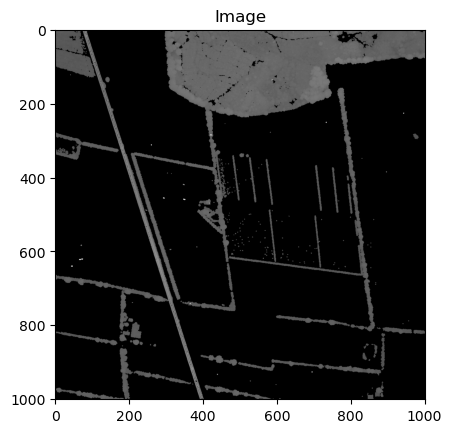

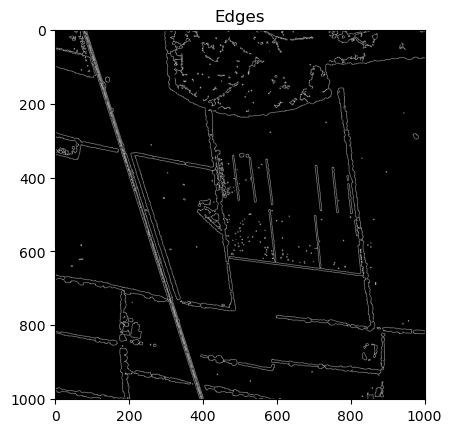

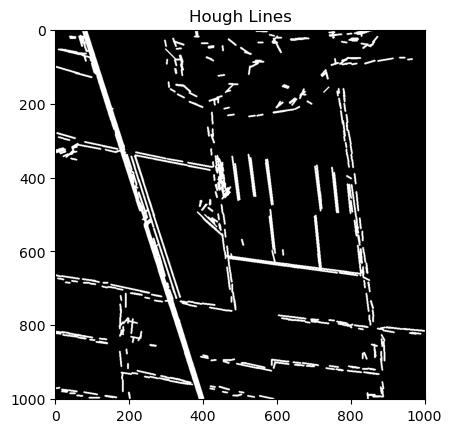

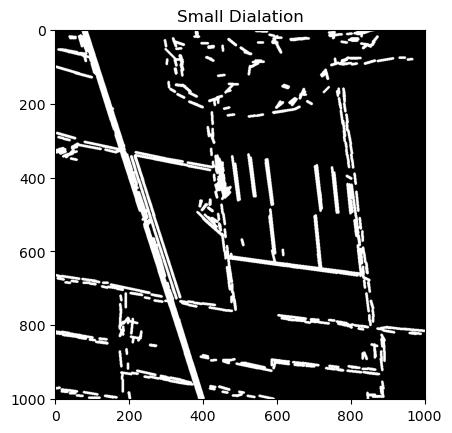

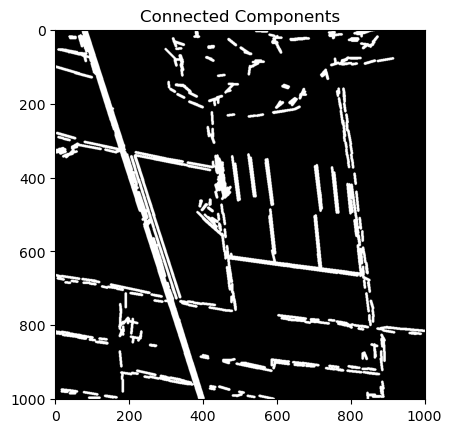

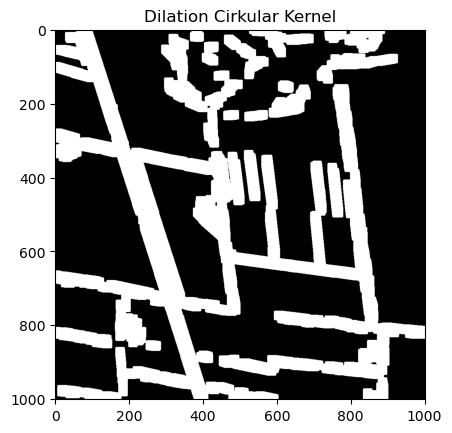

In [104]:
canny_lower = 20#best_params['canny_lower']
canny_upper = best_params['canny_upper']
closing_kernel_size = best_params['closing_kernel_size']
hough_lines_treshold = best_params['canny_lower']
max_line_gap = best_params['max_line_gap']
min_line_length = best_params['min_line_length']
meters_around_line = best_params['meters_around_line']
simplify_tolerance = best_params['simplify_tolerance']
cc_area = best_params['cc_area']


image = cv2.imread(os.path.expanduser('~')+'/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6134_518_max.tif', cv2.IMREAD_UNCHANGED)
image = np.where(image >= 0, image, 0)
image = image/np.max(image)
image = (image*255).astype(np.uint8)

plt.title("Image")
plt.imshow(image, cmap='gray')
plt.show()


# Apply edge detection method on the image
edges = cv2.Canny(image, canny_lower, canny_upper, None, 3)

plt.title("Edges")
plt.imshow(edges, cmap='gray')
plt.show()

#Parameters for cv.HoughLinesP (image, lines, rho, theta, threshold, minLineLength = 0, maxLineGap = 0)
#image	8-bit, single-channel binary source image. The image may be modified by the function.
#lines	output vector of lines(cv.32SC4 type). Each line is represented by a 4-element vector (x1,y1,x2,y2) ,where (x1,y1) and (x2,y2) are the ending points of each detected line segment.
#rho	distance resolution of the accumulator in pixels.
#theta	angle resolution of the accumulator in radians.
#threshold	accumulator threshold parameter. Only those lines are returned that get enough votes
#minLineLength	minimum line length. Line segments shorter than that are rejected.
#maxLineGap	maximum allowed gap between points on the same line to link them.

linesP = cv2.HoughLinesP(
            edges, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=hough_lines_treshold, # Min number of votes for valid line
            minLineLength=min_line_length, # Min allowed length of line
            maxLineGap=max_line_gap # Max allowed gap between line for joining them
            )

lines_image = np.zeros_like(edges)

# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(lines_image, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3)
        
plt.title("Hough Lines")
plt.imshow(lines_image, cmap='gray')
plt.show()

## Create kernel
kernel = np.ones((3, 3), np.uint8)
lines_image = cv2.dilate(lines_image, kernel, iterations=1)

plt.title("Small Dialation")
plt.imshow(lines_image, cmap='gray')
plt.show()

(_, label_ids, bounding_box, _) = cv2.connectedComponentsWithStats(lines_image)


for i in range(len(bounding_box)):
    area = bounding_box[i][cv2.CC_STAT_AREA]
    if area < cc_area:
        lines_image[label_ids == i] = 0

plt.title("Connected Components")
plt.imshow(lines_image, cmap='gray')
plt.show()

# Pixels per kilometer
x_pixels, y_pixels = image.shape

# Pixels per meter
x_pixels, y_pixels = x_pixels/1000, y_pixels/1000

meters_around_line = 10
kernel_size = int(meters_around_line*np.ceil(x_pixels))

# Create kernel
circular_kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Create a cirkular kernel using (image, center_coordinates, radius, color, thickness)
cv2.circle(circular_kernel, (int(kernel_size/2), int(kernel_size/2)), int(kernel_size/2), 255, -1)

# Perform dilation with the cirkular kernel
dilation_cirkular_kernel = cv2.dilate(lines_image, circular_kernel, iterations=1)

plt.title("Dilation Cirkular Kernel")
plt.imshow(dilation_cirkular_kernel, cmap="gray")
plt.show()

In [114]:
# Create Polygons and Multi Polygons
mask = (dilation_cirkular_kernel == 255)
output = rasterio.features.shapes(dilation_cirkular_kernel, mask=mask, connectivity=4)
output_list = list(output)
print(len(output_list))

# Seperate the Multipolygons and Polygons
all_polygons = []
all_multi_polygons =[]

for multi_polygon in output_list:
    found_polygon = multi_polygon[0]['coordinates']
    # Then its just a Polygon
    if len(found_polygon) == 1:
        all_polygons.append(Polygon(found_polygon[0]))
    # Else its a multipolygon
    else:
        tmpMulti = []
        for p in found_polygon:
            tmpMulti.append(Polygon(p))
        all_multi_polygons.append(tmpMulti)


# Remove all low area multipolygons
for i, multi_pol in enumerate(all_multi_polygons):
    new_list = [multi_pol[0]]
    # No matter what, dont remove the first one
    for pol in multi_pol[1:]:
        if pol.area > 1000:
            new_list.append(pol)
    all_multi_polygons[i] = new_list

    
simplified_all_polygons = []
simplified_all_multi_polygons =[]
# Simplify all standard polygons
for p in all_polygons:
    simplified_all_polygons.append(shapely.simplify(p, tolerance=simplify_tolerance, preserve_topology=True))
simplified_all_polygons  = [p for p in simplified_all_polygons if not p.is_empty]

# Simplify all multi polygons
for multi_pol in all_multi_polygons:
    tmp = []
    for p in multi_pol:
        tmp.append(shapely.simplify(p, tolerance=simplify_tolerance, preserve_topology=True))
    tmp  = [p for p in tmp if not p.is_empty]
    simplified_all_multi_polygons.append(tmp)
    
# Create bounding box polygons
bbox_all_polygon_path = []
tmp = [p.bounds for p in simplified_all_polygons]
for values in tmp:
    #values = (minx, miny, maxx, maxy)
    x_min = values[0]
    x_max = values[2]
    y_min = values[1]
    y_max = values[3]
    bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
    bbox_all_polygon_path.append(Path(bb))
    
# Create bounding box for multi polygons
bbox_all_multi_polygons_path = []
for multi_pol in simplified_all_multi_polygons:
    tmp = [p.bounds for p in multi_pol]
    tmp_multi_pol_boxes = []
    
    for values in tmp:
        #values = (minx, miny, maxx, maxy)
        x_min = values[0]
        x_max = values[2]
        y_min = values[1]
        y_max = values[3]
        bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
        tmp_multi_pol_boxes.append(Path(bb))
    bbox_all_multi_polygons_path.append(tmp_multi_pol_boxes)


# Create Path polygons from the simplified shapely polygons
simplified_all_polygons_path = [Path(mapping(p)['coordinates'][0]) for p in simplified_all_polygons]
simplified_all_multi_polygons_path = []
for multi_pol in simplified_all_multi_polygons:
    tmp = [Path(mapping(p)['coordinates'][0]) for p in multi_pol]
    simplified_all_multi_polygons_path.append(tmp)

15


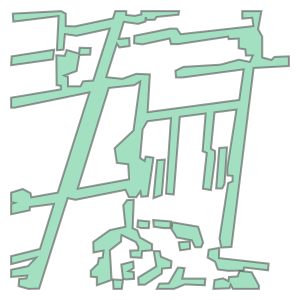

In [115]:
p = simplified_all_polygons[0]
for i in simplified_all_polygons[1:]:
    p = p.symmetric_difference(i)

for multi in simplified_all_multi_polygons:
    for i in multi:
        p = p.symmetric_difference(i)

p

In [107]:
las = laspy.read(r'/home/frederik/data/TestData/data/LazFilesWithHeightParam/PUNKTSKY_00005_1km_6134_518_hag_nn.laz')

4095


In [186]:
# Pixels per kilometer
x_pixels, y_pixels = image.shape

def MaxMinNormalize(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

def CastAllXValuesToImage(arr, x_pixels):
    return MaxMinNormalize(arr)*x_pixels

def CastAllYValuesToImage(arr, y_pixels):
    return (1-MaxMinNormalize(arr))*y_pixels

x_values = CastAllXValuesToImage(las.X, x_pixels)
y_values = CastAllYValuesToImage(las.Y, y_pixels)

# Format: [(1,1), (3,5), (1,5), ...] with 30 mio samples
list_zipped = np.array(list(zip(x_values, y_values)))

# Generate a bool list to obtain the final indexes from the dataset
indexes_needed = np.zeros(len(x_values), dtype=bool)

# Run through all polygons and check which points are inside the polygon
for i in range(len(simplified_all_polygons_path)):
    # Check if point is inside the bounding box
    indexes_inside_box = bbox_all_polygon_path[i].contains_points(list_zipped)
    indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])
    
    # Generate small dataset
    tmp = list_zipped[indexes_inside_box]
    
    # Check if any of these points are in the polygon
    indexes_inside_polygon = simplified_all_polygons_path[i].contains_points(tmp)
    
    # Find the indexes from the box that is also inside the polygon
    final_indexes = indexes_inside_box[indexes_inside_polygon]
    
    # Update the indexes
    indexes_needed[final_indexes] = 1
    
for i in range(len(simplified_all_multi_polygons_path)):
    tmp_indexes_needed = np.zeros(len(x_values), dtype=bool)
    tmp_indexes_not_needed = np.zeros(len(x_values), dtype=bool)
    
    # Get the current bb multipolygon and the current simplified multipolygon
    bb_multi_pol = bbox_all_multi_polygons_path[i]
    simpli_multi_pol = simplified_all_multi_polygons_path[i]
    
    # Find the indexes that are inside the bounding box of the first element
    indexes_inside_box = bb_multi_pol[0].contains_points(list_zipped)
    indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])
    
    # Generate smaller dataset
    tmp = list_zipped[indexes_inside_box]
    
    # Check if any of these points are in the polygon
    indexes_inside_polygon = simpli_multi_pol[0].contains_points(tmp)
    
    # Find the indexes from the box that is also inside the polygon
    final_indexes = indexes_inside_box[indexes_inside_polygon]
    tmp_indexes_needed[final_indexes] = 1
        
    for j in range(1, len(bb_multi_pol)):
        
        # Get the bounding box of the temp multi polygon
    
        indexes_inside_box = bb_multi_pol[j].contains_points(list_zipped)
        indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])
        
        # Generate small dataset
        tmp = list_zipped[indexes_inside_box]
        
        # Check if any of these points are in the polygon
        indexes_inside_polygon = simpli_multi_pol[j].contains_points(tmp)
        final_indexes = indexes_inside_box[indexes_inside_polygon]
        
        # Update the indexes
        tmp_indexes_not_needed[final_indexes] = 1
    
    indexes_needed = indexes_needed | (tmp_indexes_needed & np.invert(tmp_indexes_not_needed))

KeyboardInterrupt: 

In [35]:
# Visualise all data after removal of points
new_las = las[indexes_needed]
point_data = np.stack([new_las.X, new_las.Y, new_las.Z], axis=0).transpose((1, 0))

In [22]:


geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

[Open3D WARNING] GLFW Error: X11: Failed to convert selection to string


In [36]:
print(np.sum(las.classification == 14))
print(np.sum(new_las.classification == 14))

31418
31390


In [109]:
miss_classified_mask = (las.classification == 14) & np.invert(indexes_needed)
x_values_miss = x_values[miss_classified_mask]
y_values_miss = y_values[miss_classified_mask]

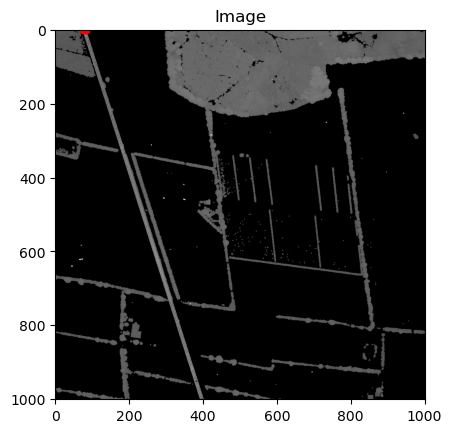

In [110]:
plt.title("Image")
plt.imshow(image, cmap='gray')
plt.scatter(x_values_miss, y_values_miss, color='r', s=20, marker='o')
plt.show()

In [187]:
def GetPathRelations(full_path_to_data):        
    ground_removed_image_paths = []
    laz_point_cloud_paths = []
        
    # Find full path to all images
    for path in glob.glob(full_path_to_data+'data/ImagesGroundRemovedSmall/*'):
        ground_removed_image_paths.append(path)
    
    # Find full path to all laz files
    for path in glob.glob(full_path_to_data+'data/LazFilesWithHeightRemoved/*'):
        laz_point_cloud_paths.append(path)
            
    ground_removed_image_paths.sort()
    laz_point_cloud_paths.sort()
    assert(len(ground_removed_image_paths)==len(laz_point_cloud_paths))
    return ground_removed_image_paths, laz_point_cloud_paths

In [191]:
def MaxMinNormalize(arr):
        return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

def CastAllXValuesToImage(arr, x_pixels):
    return MaxMinNormalize(arr)*x_pixels

def CastAllYValuesToImage(arr, y_pixels):
    return (1-MaxMinNormalize(arr))*y_pixels

def GenerateImage(path, best_params):
    image_path, laz_path = path
    
    canny_lower = 18#best_params['canny_lower']
    canny_upper = best_params['canny_upper']
    closing_kernel_size = best_params['closing_kernel_size']
    hough_lines_treshold = best_params['canny_lower']
    max_line_gap = best_params['max_line_gap']
    min_line_length = best_params['min_line_length']
    meters_around_line = best_params['meters_around_line']
    simplify_tolerance = best_params['simplify_tolerance']
    cc_area = best_params['cc_area']

    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = np.where(image >= 0, image, 0)
    image = image/np.max(image)
    image = (image*255).astype(np.uint8)

    # Apply edge detection method on the image
    edges = cv2.Canny(image, canny_lower, canny_upper, None, 3)

    #Parameters for cv.HoughLinesP (image, lines, rho, theta, threshold, minLineLength = 0, maxLineGap = 0)
    #image	8-bit, single-channel binary source image. The image may be modified by the function.
    #lines	output vector of lines(cv.32SC4 type). Each line is represented by a 4-element vector (x1,y1,x2,y2) ,where (x1,y1) and (x2,y2) are the ending points of each detected line segment.
    #rho	distance resolution of the accumulator in pixels.
    #theta	angle resolution of the accumulator in radians.
    #threshold	accumulator threshold parameter. Only those lines are returned that get enough votes
    #minLineLength	minimum line length. Line segments shorter than that are rejected.
    #maxLineGap	maximum allowed gap between points on the same line to link them.

    linesP = cv2.HoughLinesP(
                edges, # Input edge image
                1, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=hough_lines_treshold, # Min number of votes for valid line
                minLineLength=min_line_length, # Min allowed length of line
                maxLineGap=max_line_gap # Max allowed gap between line for joining them
                )


    lines_image = np.zeros_like(edges)

    # Draw the lines
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(lines_image, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3)

    ## Create kernel
    kernel = np.ones((3, 3), np.uint8)
    lines_image = cv2.dilate(lines_image, kernel, iterations=1)

    (_, label_ids, bounding_box, _) = cv2.connectedComponentsWithStats(lines_image)
    for i in range(len(bounding_box)):
        area = bounding_box[i][cv2.CC_STAT_AREA]
        if area < cc_area:
            lines_image[label_ids == i] = 0
            
    # Pixels per kilometer
    x_pixels, y_pixels = image.shape

    # Pixels per meter
    x_pixels, y_pixels = x_pixels/1000, y_pixels/1000

    meters_around_line = 10
    kernel_size = int(meters_around_line*np.ceil(x_pixels))

    # Create kernel
    circular_kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Create a cirkular kernel using (image, center_coordinates, radius, color, thickness)
    cv2.circle(circular_kernel, (int(kernel_size/2), int(kernel_size/2)), int(kernel_size/2), 255, -1)

    # Perform dilation with the cirkular kernel
    dilation_cirkular_kernel = cv2.dilate(lines_image, circular_kernel, iterations=1)

    plt.title("Dilation Cirkular Kernel")
    plt.imshow(dilation_cirkular_kernel, cmap="gray")
    plt.show()
    
    # Create Polygons and Multi Polygons
    mask = (dilation_cirkular_kernel == 255)
    output = rasterio.features.shapes(dilation_cirkular_kernel, mask=mask, connectivity=4)
    output_list = list(output)

    # Seperate the Multipolygons and Polygons
    all_polygons = []
    all_multi_polygons =[]

    for multi_polygon in output_list:
        found_polygon = multi_polygon[0]['coordinates']
        # Then its just a Polygon
        if len(found_polygon) == 1:
            all_polygons.append(Polygon(found_polygon[0]))
        # Else its a multipolygon
        else:
            tmpMulti = []
            for p in found_polygon:
                tmpMulti.append(Polygon(p))
            all_multi_polygons.append(tmpMulti)


    # Remove all low area multipolygons
    for i, multi_pol in enumerate(all_multi_polygons):
        new_list = [multi_pol[0]]
        # No matter what, dont remove the first one
        for pol in multi_pol[1:]:
            new_list.append(pol)
        all_multi_polygons[i] = new_list

    simplified_all_polygons = []
    simplified_all_multi_polygons =[]
    # Simplify all standard polygons
    for p in all_polygons:
        simplified_all_polygons.append(shapely.simplify(p, tolerance=simplify_tolerance, preserve_topology=True))
    simplified_all_polygons  = [p for p in simplified_all_polygons if not p.is_empty]

    # Simplify all multi polygons
    for multi_pol in all_multi_polygons:
        tmp = []
        for p in multi_pol:
            tmp.append(shapely.simplify(p, tolerance=simplify_tolerance, preserve_topology=True))
        tmp  = [p for p in tmp if not p.is_empty]
        simplified_all_multi_polygons.append(tmp)

    # Create bounding box polygons
    bbox_all_polygon_path = []
    tmp = [p.bounds for p in simplified_all_polygons]
    for values in tmp:
        #values = (minx, miny, maxx, maxy)
        x_min = values[0]
        x_max = values[2]
        y_min = values[1]
        y_max = values[3]
        bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
        bbox_all_polygon_path.append(Path(bb))

    # Create bounding box for multi polygons
    bbox_all_multi_polygons_path = []
    for multi_pol in simplified_all_multi_polygons:
        tmp = [p.bounds for p in multi_pol]
        tmp_multi_pol_boxes = []

        for values in tmp:
            #values = (minx, miny, maxx, maxy)
            x_min = values[0]
            x_max = values[2]
            y_min = values[1]
            y_max = values[3]
            bb = [(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]
            tmp_multi_pol_boxes.append(Path(bb))
        bbox_all_multi_polygons_path.append(tmp_multi_pol_boxes)


    # Create Path polygons from the simplified shapely polygons
    simplified_all_polygons_path = [Path(mapping(p)['coordinates'][0]) for p in simplified_all_polygons]
    simplified_all_multi_polygons_path = []
    for multi_pol in simplified_all_multi_polygons:
        tmp = [Path(mapping(p)['coordinates'][0]) for p in multi_pol]
        simplified_all_multi_polygons_path.append(tmp)
        
    
    las = laspy.read(laz_path, laz_backend=laspy.compression.LazBackend.LazrsParallel)
    
    # Pixels per kilometer
    x_pixels, y_pixels = image.shape

    x_values = CastAllXValuesToImage(las.X, x_pixels)
    y_values = CastAllYValuesToImage(las.Y, y_pixels)

    # Format: [(1,1), (3,5), (1,5), ...] with 30 mio samples
    list_zipped = np.array(list(zip(x_values, y_values)))

    # Generate a bool list to obtain the final indexes from the dataset
    indexes_needed = np.zeros(len(x_values), dtype=bool)

    # Run through all polygons and check which points are inside the polygon
    for i in range(len(simplified_all_polygons_path)):
        # Check if point is inside the bounding box
        indexes_inside_box = bbox_all_polygon_path[i].contains_points(list_zipped)
        indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])
        
        if len(indexes_inside_box) != 0:
            # Generate small dataset
            tmp = list_zipped[indexes_inside_box]

            # Check if any of these points are in the polygon
            indexes_inside_polygon = simplified_all_polygons_path[i].contains_points(tmp)

            # Find the indexes from the box that is also inside the polygon
            final_indexes = indexes_inside_box[indexes_inside_polygon]

            # Update the indexes
            indexes_needed[final_indexes] = 1

    for i in range(len(simplified_all_multi_polygons_path)):
        tmp_indexes_needed = np.zeros(len(x_values), dtype=bool)
        tmp_indexes_not_needed = np.zeros(len(x_values), dtype=bool)

        # Get the current bb multipolygon and the current simplified multipolygon
        bb_multi_pol = bbox_all_multi_polygons_path[i]
        simpli_multi_pol = simplified_all_multi_polygons_path[i]

        # Find the indexes that are inside the bounding box of the first element
        indexes_inside_box = bb_multi_pol[0].contains_points(list_zipped)
        indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])

        # Generate smaller dataset
        tmp = list_zipped[indexes_inside_box]

        # Check if any of these points are in the polygon
        indexes_inside_polygon = simpli_multi_pol[0].contains_points(tmp)

        # Find the indexes from the box that is also inside the polygon
        final_indexes = indexes_inside_box[indexes_inside_polygon]
        tmp_indexes_needed[final_indexes] = 1

        for j in range(1, len(bb_multi_pol)):

            # Get the bounding box of the temp multi polygon

            indexes_inside_box = bb_multi_pol[j].contains_points(list_zipped)
            indexes_inside_box = np.array([index for index, x in enumerate(indexes_inside_box) if x])
            
            if len(indexes_inside_box) != 0:
                # Generate small dataset
                tmp = list_zipped[indexes_inside_box]

                # Check if any of these points are in the polygon
                indexes_inside_polygon = simpli_multi_pol[j].contains_points(tmp)
                final_indexes = indexes_inside_box[indexes_inside_polygon]

                # Update the indexes
                tmp_indexes_not_needed[final_indexes] = 1

                indexes_needed = indexes_needed | (tmp_indexes_needed & np.invert(tmp_indexes_not_needed))
    
    miss_classified_mask = (las.classification == 14) & np.invert(indexes_needed)
    x_values_miss = x_values[miss_classified_mask]
    y_values_miss = y_values[miss_classified_mask]
    
    plt.title("Powerline Points Removed In Pre Processing"+"\n Points: "+str(len(x_values_miss)))
    plt.imshow(image, cmap='gray')
    plt.scatter(x_values_miss, y_values_miss, color='r', s=10, marker='x')
    plt.show()

In [192]:
all_path_relations = GetPathRelations("/home/frederik/data/TestData/")
path_tuples = list(zip(*all_path_relations))

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6134_518_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6134_518_height_filtered.laz')


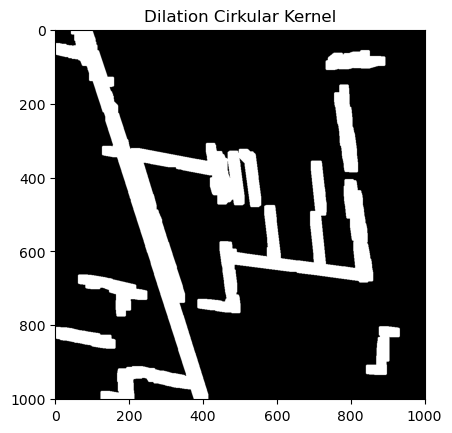

4095


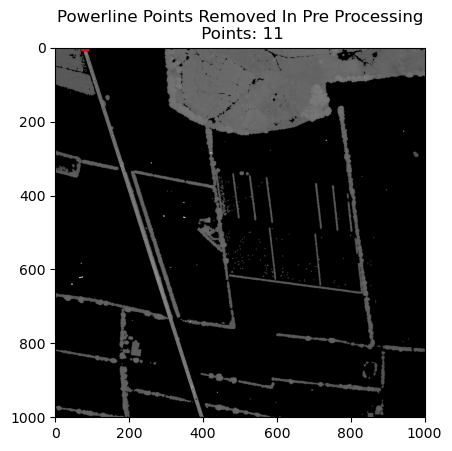

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6146_468_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6146_468_height_filtered.laz')


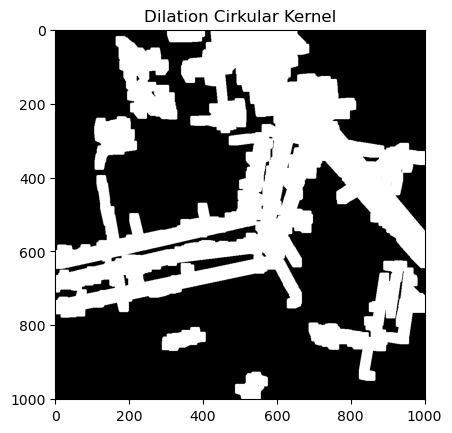

4095


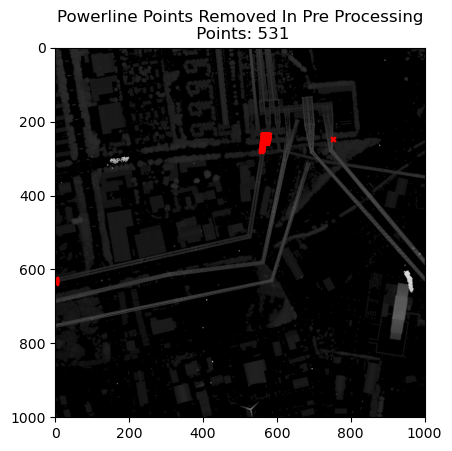

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6161_465_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6161_465_height_filtered.laz')


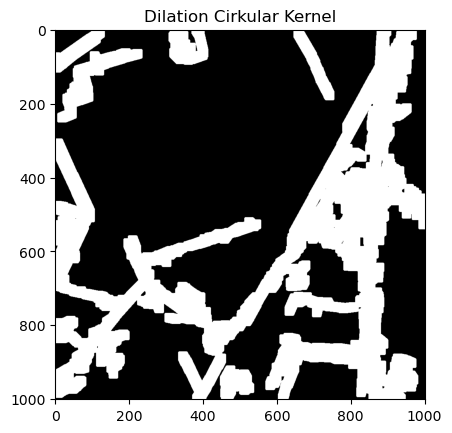

4095


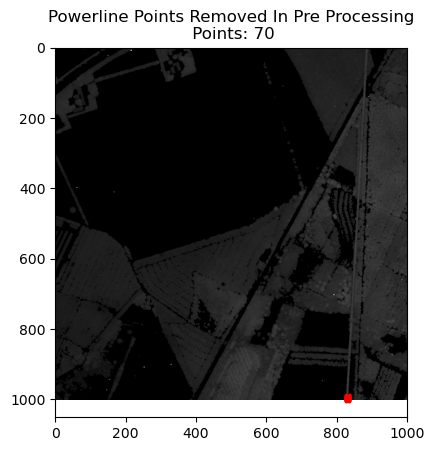

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6162_472_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6162_472_height_filtered.laz')


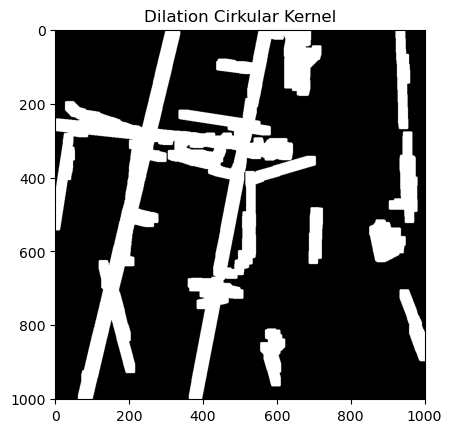

4095


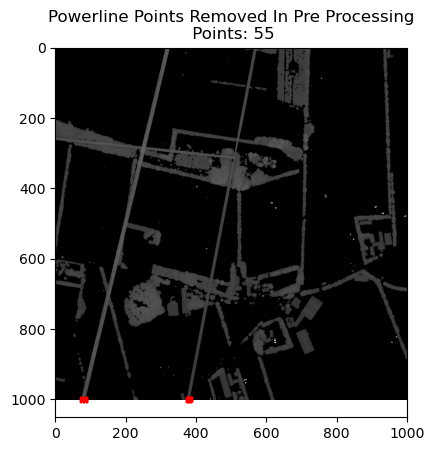

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6163_472_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6163_472_height_filtered.laz')


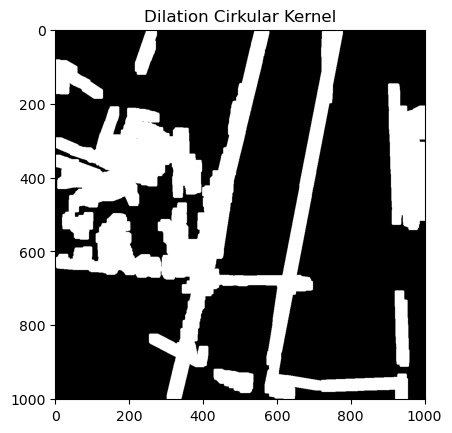

4095


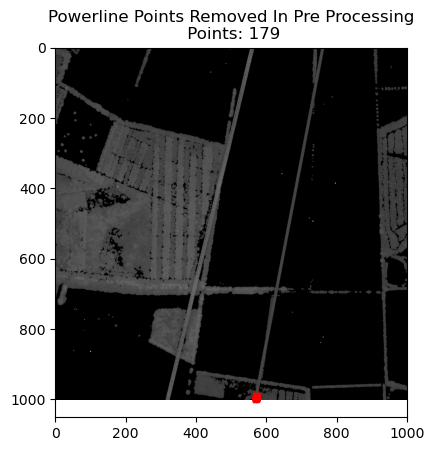

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6167_473_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6167_473_height_filtered.laz')


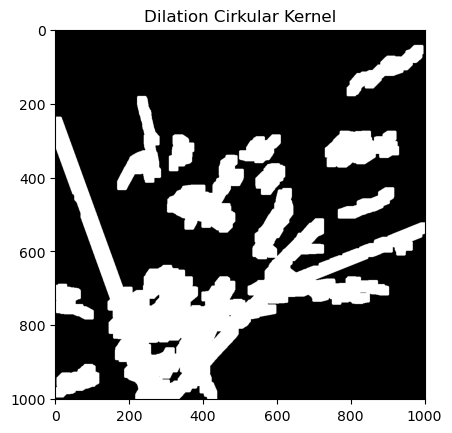

4095


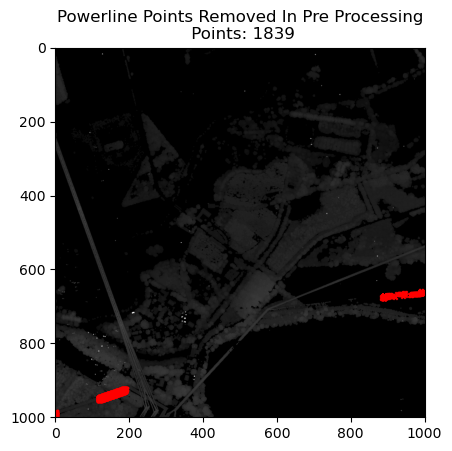

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6167_474_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6167_474_height_filtered.laz')


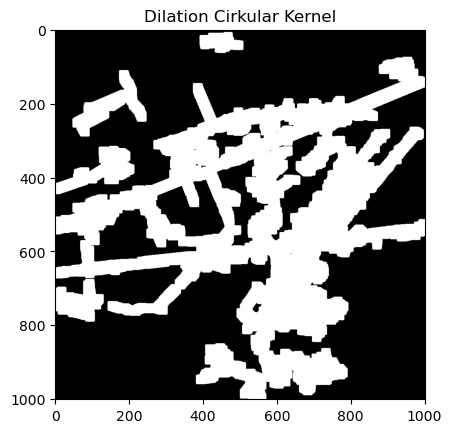

4095


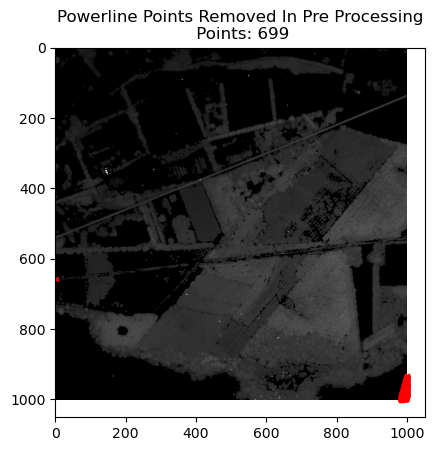

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6167_475_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6167_475_height_filtered.laz')


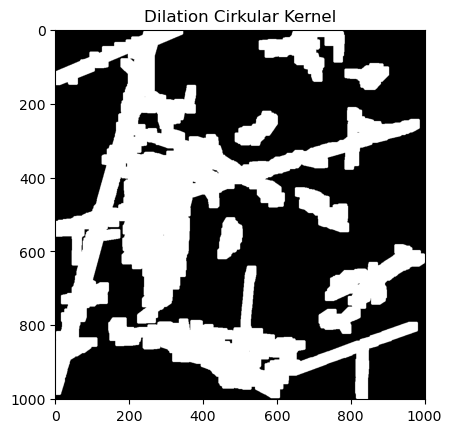

4095


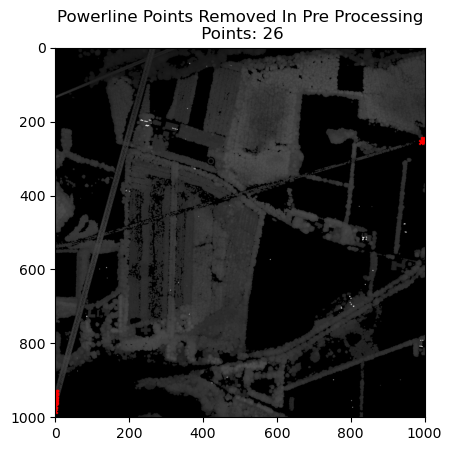

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6168_458_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6168_458_height_filtered.laz')


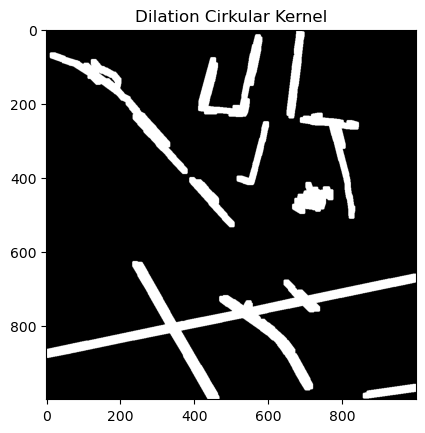

4095


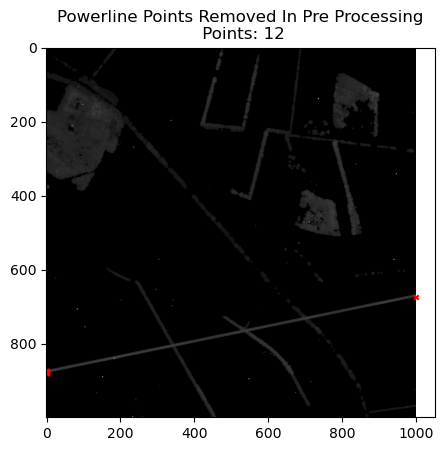

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6204_505_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6204_505_height_filtered.laz')


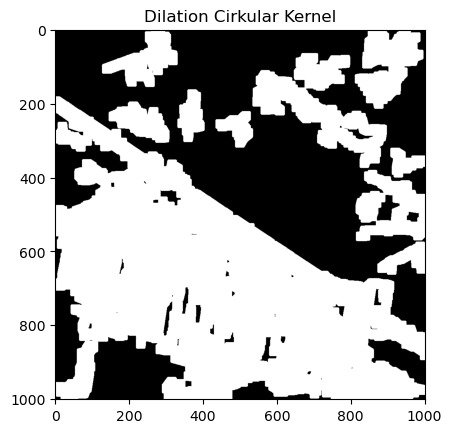

4095


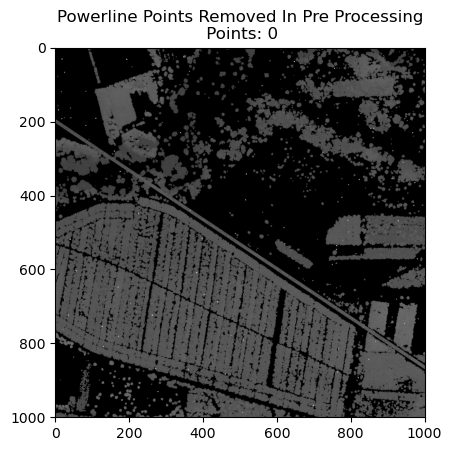

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6205_513_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6205_513_height_filtered.laz')


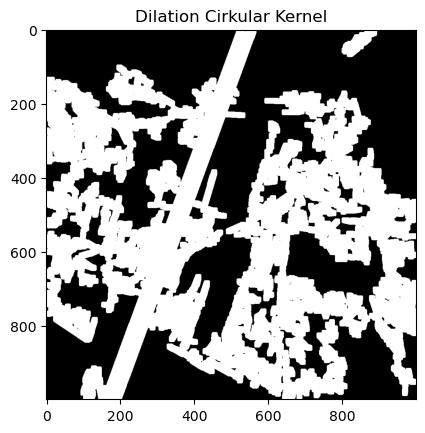

4095


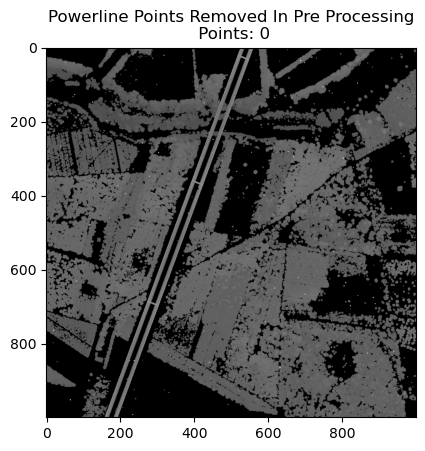

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6211_474_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6211_474_height_filtered.laz')


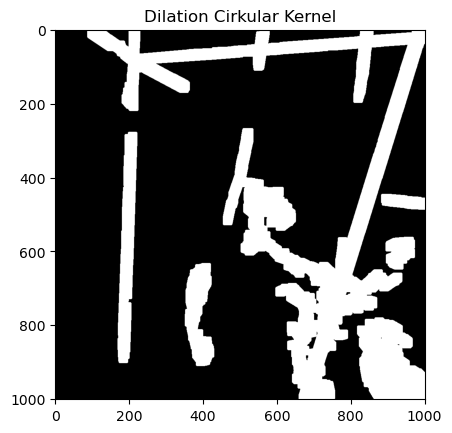

4095


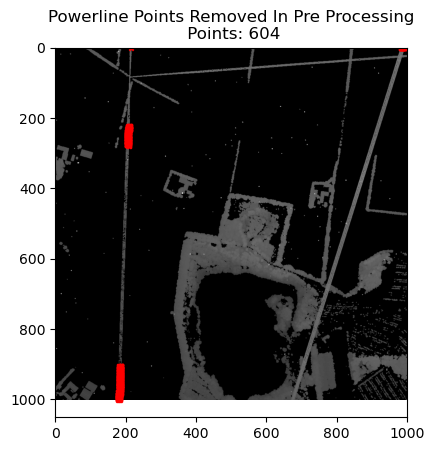

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6219_494_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6219_494_height_filtered.laz')


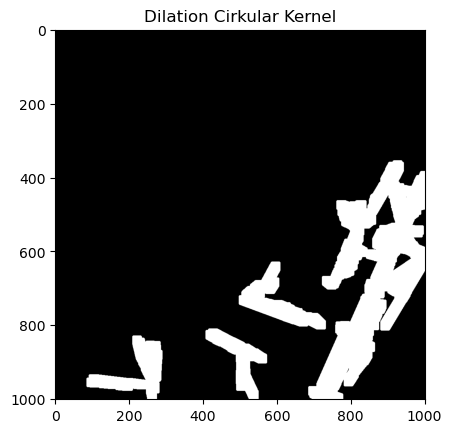

4095


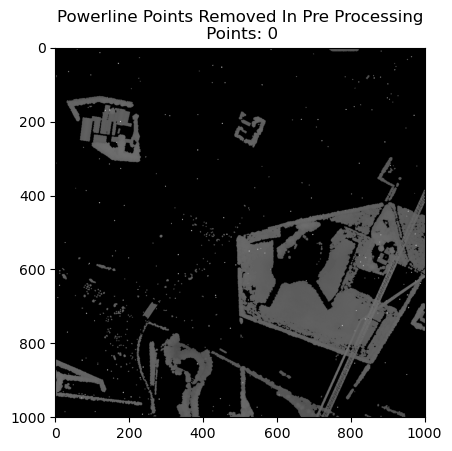

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6220_495_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6220_495_height_filtered.laz')


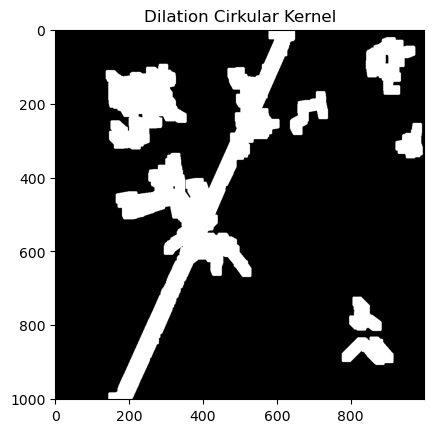

4095


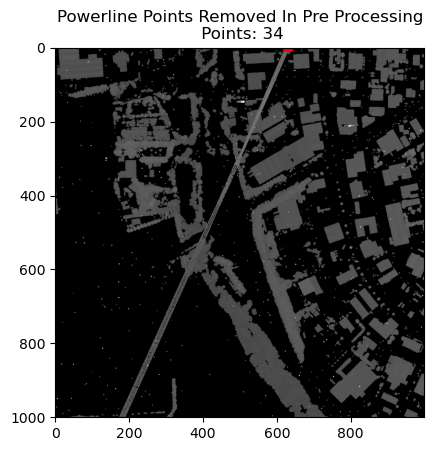

('/home/frederik/data/TestData/data/ImagesGroundRemovedSmall/PUNKTSKY_00005_1km_6221_452_max.tif', '/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6221_452_height_filtered.laz')


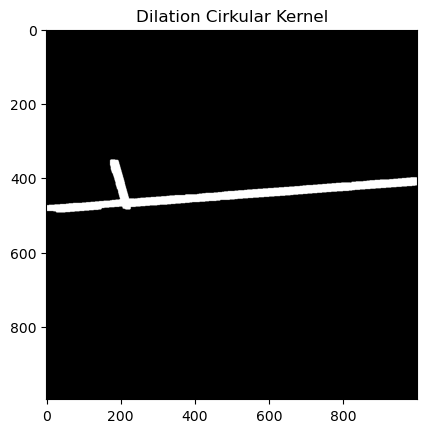

4095


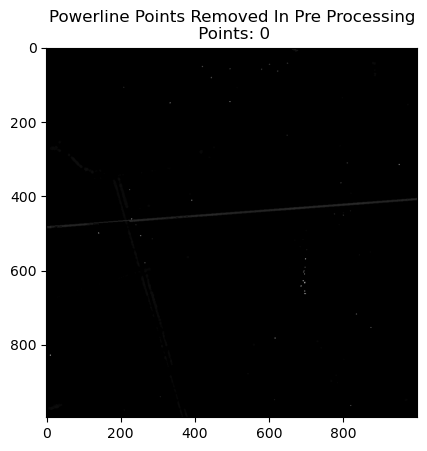

In [193]:
for p in path_tuples:
    print(p)
    GenerateImage(p, best_params)

In [169]:
p = "/home/frederik/data/TestData/data/LazFilesWithHeightRemoved/PUNKTSKY_00005_1km_6161_465_height_filtered.laz"
las = laspy.read(p)
point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))

4095


In [170]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])